In [1]:
import pandas as pd
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
import pandas as pd
import rdchiral
import itertools
import pickle
import sys
from tqdm import tqdm 
from rdchiral.main import rdchiralRun, rdchiralRunText, rdchiralReaction, rdchiralReactants
import cobra
from itertools import chain, combinations
import sys
import multiprocessing
from functools import partial
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
sys.path.append('../retrosynthesis/')

from common import *

### input and output

In [2]:
# step1
#input
mnxreac_smile_atom_mapping_rules_file_path = '../../Results/rules/MNXreaction_smiles_atommap_rules_filter.csv'
figs1_path = '../../Results/Figures/figs1.pdf'

In [3]:
def process_rule(rule_smiles, mets_total_smiles):
    score = []
    smiles = []
    if 'C' in rule_smiles or 'c' in rule_smiles:
        for j in mets_total_smiles:
            current_score = calculate_similarity(rule_smiles, j)
            if current_score > 0.3:
                score.append(current_score)
                smiles.append(j)
    else:
        smiles.append(rule_smiles)
        score.append(1)

    if len(score) == 0:
        return rule_smiles, [], []
    elif len(score) > 20:
        top40_data = sorted(zip(score, smiles), reverse=True)[:20]
    else:
        top40_data = sorted(zip(score, smiles), reverse=True)
    
    top40_scores, top40_smiles = zip(*top40_data)
    
    return rule_smiles, list(top40_smiles), list(top40_scores)

In [4]:
def process_retrorule(index_row, mets_total_smiles,retrosys_smiles_calculate_similarity_pd,heterologous_met_smiles):
    rxndb_list_tmp = []
    # newdbSmiles_tmp = []
    failedrxn_tmp = []
    index, row = index_row
    rxn_id, ECnumber, reactants, products = row['MNX_ID'], row['classifs'], row['substrate_smiles'], row['product_smiles']
    deprecated_equ_smiles, reactantSMARTs, productSMARTs, rule = row['deprecated_equ_smiles'], row['ReactantsSMARTs'], row['ProductSMARTs'], row['RetroRules']
    deprecated_equ_smiles = deprecated_equ_smiles.split('>>')
    if rxn_id not in ['MNXR101882', 'MNXR101884', 'MNXR101879', 'MNXR101885', 'MNXR101886', 'MNXR101887',
                        'MNXR103528', 'MNXR103575']:  # ATP NADH conversion stuff
        productSMARTs = productSMARTs.split('.')
        products = products.split('.')
        new_products_smiles = []
        scores = []

        if len(productSMARTs) == len(products):
            for x in range(len(productSMARTs)):  # prepare mets with substructure and sort the reactants combination
                new_products_smile_one,score_one = get_calculate_similarity(products[x],retrosys_smiles_calculate_similarity_pd)
                new_products_smiles.append(new_products_smile_one)
                scores.append(score_one)

            product_prepared = []
            scores_prepared = []
            for lst, score_lst in zip(new_products_smiles, scores):
                if heterologous_met_smiles in lst:
                    if len(new_products_smiles) == 1:  # if only one sub list
                        product_prepared.append([heterologous_met_smiles])
                        scores_prepared.append(score_lst)
                    else:
                        other_lists = [sub_lst for sub_lst in new_products_smiles if sub_lst != lst]
                        tmp_product = list(itertools.product([heterologous_met_smiles], *other_lists))
                        product_prepared += tmp_product

                        tmp_scores = list(itertools.product([score_lst[new_products_smiles.index(lst)]], *scores))
                        scores_prepared += tmp_scores

            for m in range(0, len(product_prepared)):  # apply the rule and output the rxn
                smile = product_prepared[m]
                score = scores_prepared[m]
                
                if len(smile) > 1:
                    product_smile = '.'.join(smile)
                else:
                    product_smile = smile[0]

                retrorule_tmp = rule.split('>>')
                retrorule_tmp = '(' + retrorule_tmp[0] + ')>>' + '(' + retrorule_tmp[1] + ')'            
                product_smile_tmp = product_smile
                try:
                    # print('product_smile_tmp',product_smile_tmp)
                    product_mol = Chem.MolFromSmiles(product_smile_tmp)
                    reaction = AllChem.ReactionFromSmarts(retrorule_tmp)
                    reactant_smiles = reaction.RunReactants((product_mol,))
                    smiles = [Chem.MolToSmiles(x[0]) for x in reactant_smiles]
                    reactant_smiles = list(set(smiles))

                    for reactant_smile in reactant_smiles:
                        if len(deprecated_equ_smiles) > 0:
                            if deprecated_equ_smiles[0] == '':
                                reactant_smile_final = reactant_smile
                            else:
                                reactant_smile_final = reactant_smile + '.' + deprecated_equ_smiles[0]
                            if deprecated_equ_smiles[1] == '':
                                product_smile_final = product_smile_tmp
                            else:
                                product_smile_final = product_smile_tmp + '.' + deprecated_equ_smiles[1]
                        rxn_smiles = reactant_smile + '>>' + product_smile_tmp
                        rxn_smiles_final = reactant_smile_final + '>>' + product_smile_final
                        
                        tmp = {
                            'EC number': ECnumber,
                            'rule': rule,
                            'templateID': rxn_id,
                            'templateSubstrate': products,
                            'rxn_smiles_basic': rxn_smiles,
                            'rxn_smiles_final': rxn_smiles_final,
                            'reactant_smile': reactant_smile,
                            'productsmile': product_smile_tmp,
                            'similarity': score
                        }
                        if check_rule(tmp['rxn_smiles_basic'])=='blance':
                            rxndb_list_tmp.append(tmp)  
                            # mets_tmp = reactant_smile.split('.')      
                            # for reactant in mets_tmp:             
                            #     if reactant not in mets_total_smiles and reactant not in newdbSmiles_tmp:         
                            #         newdbSmiles_tmp.append(reactant)        
                except:
                    failedrxn_tmp.append(rxn_id)
                
    return(rxndb_list_tmp,failedrxn_tmp)

In [5]:
def process_retrorule(index_row, mets_total_smiles,retrosys_smiles_calculate_similarity_pd):
    rxndb_list_tmp = []
    # newdbSmiles_tmp = []
    failedrxn_tmp = []
    index, row = index_row
    rxn_id, ECnumber, reactants, products = row['MNX_ID'], row['classifs'], row['substrate_smiles'], row['product_smiles']
    deprecated_equ_smiles, reactantSMARTs, productSMARTs, rule = row['deprecated_equ_smiles'], row['ReactantsSMARTs'], row['ProductSMARTs'], row['RetroRules']
    deprecated_equ_smiles = deprecated_equ_smiles.split('>>')
    if rxn_id not in ['MNXR101882', 'MNXR101884', 'MNXR101879', 'MNXR101885', 'MNXR101886', 'MNXR101887',
                        'MNXR103528', 'MNXR103575']:  # ATP NADH conversion stuff
        productSMARTs = productSMARTs.split('.')
        products = products.split('.')
        new_products_smiles = []
        scores = []

        if len(productSMARTs) == len(products):
            for x in range(len(productSMARTs)):  # prepare mets with substructure and sort the reactants combination
                new_products_smile_one,score_one = get_calculate_similarity(products[x],retrosys_smiles_calculate_similarity_pd)
                new_products_smiles.append(new_products_smile_one)
                scores.append(score_one)

            product_prepared = []
            scores_prepared = []
            for lst, score_lst in zip(new_products_smiles, scores):
                new_products_smiles.append(lst[:40])
                scores.append(score_lst[:40])
                product_prepared = list(itertools.product(*new_products_smiles))
                scores_prepared = list(itertools.product(*scores))
                # if heterologous_met_smiles in lst:
                #     if len(new_products_smiles) == 1:  # if only one sub list
                #         product_prepared.append([heterologous_met_smiles])
                #         scores_prepared.append(score_lst)
                #     else:
                #         other_lists = [sub_lst for sub_lst in new_products_smiles if sub_lst != lst]
                #         tmp_product = list(itertools.product([heterologous_met_smiles], *other_lists))
                #         product_prepared += tmp_product

                #         tmp_scores = list(itertools.product([score_lst[new_products_smiles.index(lst)]], *scores))
                #         scores_prepared += tmp_scores
                
            for m in range(0, len(product_prepared)):  # apply the rule and output the rxn
                smile = product_prepared[m]
                score = scores_prepared[m]
                
                if len(smile) > 1:
                    product_smile = '.'.join(smile)
                else:
                    product_smile = smile[0]

                retrorule_tmp = rule.split('>>')
                retrorule_tmp = '(' + retrorule_tmp[0] + ')>>' + '(' + retrorule_tmp[1] + ')'            
                product_smile_tmp = product_smile
                try:
                    # print('product_smile_tmp',product_smile_tmp)
                    product_mol = Chem.MolFromSmiles(product_smile_tmp)
                    reaction = AllChem.ReactionFromSmarts(retrorule_tmp)
                    reactant_smiles = reaction.RunReactants((product_mol,))
                    smiles = [Chem.MolToSmiles(x[0]) for x in reactant_smiles]
                    reactant_smiles = list(set(smiles))

                    for reactant_smile in reactant_smiles:
                        if len(deprecated_equ_smiles) > 0:
                            if deprecated_equ_smiles[0] == '':
                                reactant_smile_final = reactant_smile
                            else:
                                reactant_smile_final = reactant_smile + '.' + deprecated_equ_smiles[0]
                            if deprecated_equ_smiles[1] == '':
                                product_smile_final = product_smile_tmp
                            else:
                                product_smile_final = product_smile_tmp + '.' + deprecated_equ_smiles[1]
                        rxn_smiles = reactant_smile + '>>' + product_smile_tmp
                        rxn_smiles_final = reactant_smile_final + '>>' + product_smile_final
                        
                        tmp = {
                            'EC number': ECnumber,
                            'rule': rule,
                            'templateID': rxn_id,
                            'templateSubstrate': products,
                            'rxn_smiles_basic': rxn_smiles,
                            'rxn_smiles_final': rxn_smiles_final,
                            'reactant_smile': reactant_smile,
                            'productsmile': product_smile_tmp,
                            'similarity': score
                        }
                        if check_rule(tmp['rxn_smiles_basic'])=='blance':
                            rxndb_list_tmp.append(tmp)  
                            # mets_tmp = reactant_smile.split('.')      
                            # for reactant in mets_tmp:             
                            #     if reactant not in mets_total_smiles and reactant not in newdbSmiles_tmp:         
                            #         newdbSmiles_tmp.append(reactant)        
                except:
                    failedrxn_tmp.append(rxn_id)
                
    return(rxndb_list_tmp,failedrxn_tmp)

In [6]:
def check_two_substrate_smiles_equal(substrate_smiles, substrate_smiles_pred):
    """
    Checks if every SMILES in substrate_smiles has at least one match in substrate_smiles_pred.

    Args:
        substrate_smiles (list of str): Reference SMILES strings.
        substrate_smiles_pred (list of str): Predicted SMILES strings.

    Returns:
        int: 1 if all SMILES in substrate_smiles have at least one match, else 0.
    """
    substrate_smiles = [x for x in substrate_smiles if smiles_has_carbon(x)]
    substrate_smiles_pred = [x for x in substrate_smiles_pred if smiles_has_carbon(x)]
    if not substrate_smiles or not substrate_smiles_pred:
        # Return 0 if either list is empty
        return 0

    # Check if each SMILES in substrate_smiles has a match in substrate_smiles_pred
    all_match = all(
        any(compare_smiles_inchikey(x, y) == 1 for y in substrate_smiles_pred)
        for x in substrate_smiles
    )
    return 1 if all_match else 0

In [7]:
retrorules = pd.read_csv(mnxreac_smile_atom_mapping_rules_file_path)
print(retrorules.shape)
retrorules = retrorules[retrorules['MNX_ID'].apply(lambda x:x.split('_')[0] not in ['MNXR101882', 'MNXR101884', 'MNXR101879', 'MNXR101885', 
                                                             'MNXR101886', 'MNXR101887','MNXR103528', 'MNXR103575'])]# ATP NADH conversion stuff
print(retrorules.shape)

(21921, 19)
(21911, 19)


In [8]:
success_rules = []
fail_rules = []
for index,row in retrorules.iterrows():
    # print(index)
    substrate_smiles_tmp = row['substrate_smiles']
    rules_product_smiles_lst = []
    product_smiles_tmp  = row['product_smiles'].split('.')
    for i in product_smiles_tmp:
        if i not in rules_product_smiles_lst:
            rules_product_smiles_lst.append(i)
    # print('rules_product_smiles_lst',len(rules_product_smiles_lst),rules_product_smiles_lst)

    new_model_and_heterologous_met = rules_product_smiles_lst
    # print(len(new_model_and_heterologous_met))

    #calculate similarity
    num_processes = 10
    pool = multiprocessing.Pool(num_processes)
    retrosys_smiles_calculate_similarity = {'rules_smiles': [],
                                            'smiles_in_mets_total_smiles': [],
                                            'scores': []}


    process_rule_partial = partial(process_rule, mets_total_smiles=new_model_and_heterologous_met)
    for result in tqdm(pool.imap(process_rule_partial, rules_product_smiles_lst, chunksize=5), total=len(rules_product_smiles_lst)):
        if result[0] not in retrosys_smiles_calculate_similarity['rules_smiles']:
            retrosys_smiles_calculate_similarity['rules_smiles'].append(result[0]) 
            retrosys_smiles_calculate_similarity['smiles_in_mets_total_smiles'].append(result[1]) 
            retrosys_smiles_calculate_similarity['scores'].append(result[2]) 


    retrosys_smiles_calculate_similarity_pd = pd.DataFrame(retrosys_smiles_calculate_similarity)
    retrosys_smiles_calculate_similarity_pd    

    pool.close()
    pool.join()

    ### retrosys
    rxndb_list_tmp = []
    failedrxn_tmp = []
    rxn_id, ECnumber, reactants, products = row['MNX_ID'], row['classifs'], row['substrate_smiles'], row['product_smiles']
    deprecated_equ_smiles, reactantSMARTs, productSMARTs, rule = row['deprecated_equ_smiles'], row['ReactantsSMARTs'], row['ProductSMARTs'], row['RetroRules']
    deprecated_equ_smiles = deprecated_equ_smiles.split('>>')
    productSMARTs = productSMARTs.split('.')
    products = products.split('.')
    # print('products',products)
    new_products_smiles = []
    scores = []

    if len(productSMARTs) == len(products):
        for x in range(len(productSMARTs)):  # prepare mets with substructure and sort the reactants combination
            # print('products[x]',x,products[x])
            new_products_smile_one,score_one = get_calculate_similarity(products[x],retrosys_smiles_calculate_similarity_pd)
            new_products_smiles.append(new_products_smile_one)
            scores.append(score_one)

        product_prepared = []
        scores_prepared = []

        for lst, score_lst in zip(new_products_smiles, scores):
            # 确保 new_products_smiles 和 scores 是静态的，不在循环中修改
            product_prepared = list(itertools.product(*new_products_smiles))
            scores_prepared = list(itertools.product(*scores))
        for m in range(0, len(product_prepared)):  # apply the rule and output the rxn
            # print(m)
            smile = product_prepared[m]
            score = scores_prepared[m]
            
            if len(smile) > 1:
                product_smile = '.'.join(smile)
            else:
                product_smile = smile[0]

            retrorule_tmp = rule.split('>>')
            retrorule_tmp = '(' + retrorule_tmp[0] + ')>>' + '(' + retrorule_tmp[1] + ')'            
            product_smile_tmp = product_smile
            # print(product_smile_tmp)
            try:
                # print('product_smile_tmp',product_smile_tmp)
                product_mol = Chem.MolFromSmiles(product_smile_tmp)
                reaction = AllChem.ReactionFromSmarts(retrorule_tmp)
                reactant_smiles = reaction.RunReactants((product_mol,))
                # print('reactant_smiles',reactant_smiles)
                smiles = [Chem.MolToSmiles(x[0]) for x in reactant_smiles]
                reactant_smiles = list(set(smiles))
                # print('reactant_smiles',reactant_smiles)
                for reactant_smile in reactant_smiles:
                    if len(deprecated_equ_smiles) > 0:
                        if deprecated_equ_smiles[0] == '':
                            reactant_smile_final = reactant_smile
                        else:
                            reactant_smile_final = reactant_smile + '.' + deprecated_equ_smiles[0]
                        if deprecated_equ_smiles[1] == '':
                            product_smile_final = product_smile_tmp
                        else:
                            product_smile_final = product_smile_tmp + '.' + deprecated_equ_smiles[1]
                    rxn_smiles = reactant_smile + '>>' + product_smile_tmp
                    rxn_smiles_final = reactant_smile_final + '>>' + product_smile_final
                    
                    tmp = {
                        'EC number': ECnumber,
                        'rule': rule,
                        'templateID': rxn_id,
                        'templateSubstrate': products,
                        'rxn_smiles_basic': rxn_smiles,
                        'rxn_smiles_final': rxn_smiles_final,
                        'reactant_smile': reactant_smile,
                        'productsmile': product_smile_tmp,
                        'similarity': score
                    }
                    if check_rule(tmp['rxn_smiles_basic'])=='blance':
                        rxndb_list_tmp.append(tmp)  
                        # mets_tmp = reactant_smile.split('.')      
                        # for reactant in mets_tmp:             
                        #     if reactant not in mets_total_smiles and reactant not in newdbSmiles_tmp:         
                        #         newdbSmiles_tmp.append(reactant)        
            except:
                failedrxn_tmp.append(rxn_id)

    check_result = 0
    for rxndb_tmp in rxndb_list_tmp:
        # print(rxndb_tmp['rxn_smiles_basic'])
        substrate_smiles_pred = rxndb_tmp['rxn_smiles_basic'].split('>>')[0]
        if check_two_substrate_smiles_equal(substrate_smiles_tmp,substrate_smiles_pred):
            check_result = 1


    if check_result==1:
        success_rules.append(row['MNX_ID'])
    else:
        fail_rules.append(row['MNX_ID'])
            

100%|██████████| 2/2 [00:00<00:00, 271.34it/s]


In [9]:
print(len(success_rules))
print(len(fail_rules))

20901
1010


In [ ]:
20901/(20901+1010)

0.9539044315640546

In [ ]:
fail_rules

['MNXR100277',
 'MNXR100328',
 'MNXR100329',
 'MNXR100329_reverse',
 'MNXR100348',
 'MNXR100390',
 'MNXR100492',
 'MNXR100492_reverse',
 'MNXR100611',
 'MNXR100611_reverse',
 'MNXR100737',
 'MNXR100737_reverse',
 'MNXR101251_reverse',
 'MNXR101456',
 'MNXR101456_reverse',
 'MNXR101798',
 'MNXR101798_reverse',
 'MNXR101937_reverse',
 'MNXR101938_reverse',
 'MNXR101939',
 'MNXR101940',
 'MNXR102010',
 'MNXR102010_reverse',
 'MNXR102063',
 'MNXR102063_reverse',
 'MNXR102068',
 'MNXR102068_reverse',
 'MNXR102069',
 'MNXR102069_reverse',
 'MNXR102272',
 'MNXR102272_reverse',
 'MNXR102281',
 'MNXR102281_reverse',
 'MNXR103045',
 'MNXR103050',
 'MNXR103050_reverse',
 'MNXR103099',
 'MNXR103099_reverse',
 'MNXR103357',
 'MNXR103357_reverse',
 'MNXR103361',
 'MNXR103362',
 'MNXR103371',
 'MNXR103371_reverse',
 'MNXR103381_reverse',
 'MNXR104379',
 'MNXR104379_reverse',
 'MNXR104485',
 'MNXR104485_reverse',
 'MNXR104649_reverse',
 'MNXR104885',
 'MNXR104888',
 'MNXR104898',
 'MNXR104898_reverse'

In [ ]:
retrorules.head(3)

,MNX_ID,equation,REFERENCE,classifs,is_balanced,is_transport,substrate_smiles,product_smiles,equ_name,equ_smiles,deprecated_equ,deprecated_equ_smiles,RxnMapped,confidence,ReactantsSMARTs,ProductSMARTs,RetroRules,Radius,num_substrings
0,MNXR100024,1 MNXM1@MNXD1 + 1 MNXM37@MNXD1 + 1 MNXM40333@M...,rheaR:16169,6.3.1.2,B,NaN,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],L-glutamine + H2O <=> NH4(+) + L-glutamate,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H]>>[NH4+]...,H(+) + ADP + phosphate <=> ATP + H2O,[H+].Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])...,[NH3+:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[N...,0.984627,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:3])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,1.0,2
1,MNXR100024_reverse,1 MNXM3@MNXD1 + 1 MNXM729302@MNXD1 + 1 MNXM741...,rheaR:16169,6.3.1.2,B,NaN,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],NH4(+) + L-glutamate <=> L-glutamine + H2O,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>NC(...,ATP + H2O <=> H(+) + ADP + phosphate,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,[C:2](=[O:3])([CH2:4][CH2:5][C@H:6]([NH3+:7])[...,0.876969,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:3])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,1.0,2
2,MNXR100030,1 MNXM37@MNXD1 + 1 WATER@MNXD1 <=> 1 MNXM72930...,rheaR:15889,1.4.1.13;1.4.1.14;1.4.7.1;2.4.2;2.4.2.14;3.5.1...,B,NaN,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],L-glutamine + H2O <=> NH4(+) + L-glutamate,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H]>>[NH4+]...,<=>,>>,[NH3+:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[N...,0.984627,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:3])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,1.0,2


In [13]:
retrorules['classifs'] = retrorules['classifs'].apply(lambda x:x.split(';'))

In [14]:
# Define a function to validate EC numbers
def is_valid_ec_number(ec_number):
    """
    Validates if an EC number is in the correct format.
    Uses a regular expression to match a valid 4-part EC number:
    1. Composed of four groups of digits separated by '.'.
    2. For example: '1.1.1.1' is valid, but '1.1.1' or '1.1.1.a' are not valid.
    
    Parameters:
    - ec_number (str): The EC number to validate.

    Returns:
    - bool: True if valid, False if invalid.
    """
    pattern = r"^\d+\.\d+\.\d+\.\d+$"  # Regular expression for matching EC number
    return bool(re.match(pattern, ec_number))

# Example usage
examples = ["1.1.1.1", "1.1.1", "1.1.1.-", "1.1.1.1-"]
example_results = [is_valid_ec_number(ec) for ec in examples]
print(f"Validation results: {dict(zip(examples, example_results))}")

Validation results: {'1.1.1.1': True, '1.1.1': False, '1.1.1.-': False, '1.1.1.1-': False}


In [15]:
retrorules['classifs'] = retrorules['classifs'].apply(lambda x:[ec for ec in x if is_valid_ec_number(ec)])

In [16]:
expanded_retrorules = retrorules.explode('classifs', ignore_index=True)

In [17]:
expanded_retrorules.head(3)

,MNX_ID,equation,REFERENCE,classifs,is_balanced,is_transport,substrate_smiles,product_smiles,equ_name,equ_smiles,deprecated_equ,deprecated_equ_smiles,RxnMapped,confidence,ReactantsSMARTs,ProductSMARTs,RetroRules,Radius,num_substrings
0,MNXR100024,1 MNXM1@MNXD1 + 1 MNXM37@MNXD1 + 1 MNXM40333@M...,rheaR:16169,6.3.1.2,B,NaN,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],L-glutamine + H2O <=> NH4(+) + L-glutamate,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H]>>[NH4+]...,H(+) + ADP + phosphate <=> ATP + H2O,[H+].Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])...,[NH3+:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[N...,0.984627,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:3])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,1.0,2
1,MNXR100024_reverse,1 MNXM3@MNXD1 + 1 MNXM729302@MNXD1 + 1 MNXM741...,rheaR:16169,6.3.1.2,B,NaN,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],NH4(+) + L-glutamate <=> L-glutamine + H2O,[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-]>>NC(...,ATP + H2O <=> H(+) + ADP + phosphate,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O...,[C:2](=[O:3])([CH2:4][CH2:5][C@H:6]([NH3+:7])[...,0.876969,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:3])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:5])=[O;D1;H0:...,1.0,2
2,MNXR100030,1 MNXM37@MNXD1 + 1 WATER@MNXD1 <=> 1 MNXM72930...,rheaR:15889,1.4.1.13,B,NaN,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H],[NH4+].[NH3+][C@@H](CCC(=O)[O-])C(=O)[O-],L-glutamine + H2O <=> NH4(+) + L-glutamate,NC(=O)CC[C@H]([NH3+])C(=O)[O-].[H]O[H]>>[NH4+]...,<=>,>>,[NH3+:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[N...,0.984627,[C:1]-[C;H0;D3;+0:2](-[NH2;D1;+0:3])=[O;D1;H0:...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,[C:1]-[C;H0;D3;+0:2](-[O-;H0;D1:5])=[O;D1;H0:4...,1.0,2


In [18]:
expanded_retrorules = expanded_retrorules[~expanded_retrorules['classifs'].isna()]

In [19]:
# 计算 total_rule
for ec in ['1','2','3','4','5','6','7']:
    total_rule = len(expanded_retrorules[expanded_retrorules['classifs'].str.startswith(ec)])

    # 计算 success_rule
    success_rule = len(expanded_retrorules[
        (expanded_retrorules['classifs'].str.startswith(ec)) &
        (expanded_retrorules['MNX_ID'].isin(success_rules))
    ])

    # 计算 success_ratio
    success_ratio = success_rule / total_rule if total_rule > 0 else 0  # 防止除以0
    print('EC',ec,': ',success_rule,'/',total_rule,' = ',success_ratio)

EC 1 :  10346 / 10782  =  0.9595622333518827
EC 2 :  3306 / 3918  =  0.8437978560490046
EC 3 :  3863 / 3972  =  0.9725579053373615
EC 4 :  1959 / 1973  =  0.9929042067916878
EC 5 :  775 / 783  =  0.9897828863346104
EC 6 :  467 / 483  =  0.9668737060041408
EC 7 :  0 / 0  =  0


meta NOT subset; don't know how to subset; dropped


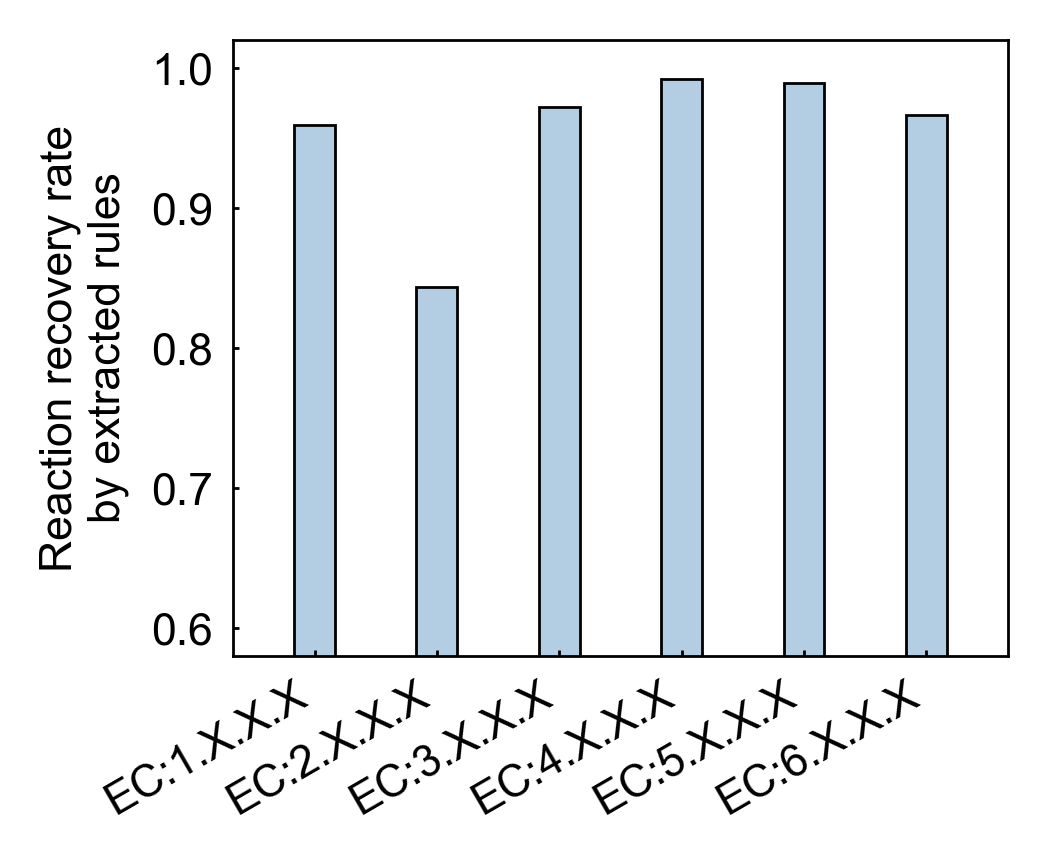

In [20]:
# Set general parameters
plt.figure(figsize=(2.5, 2), dpi=400)
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Set axis styles
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# Data
labels = ['EC:1.X.X.X', 'EC:2.X.X.X', 'EC:3.X.X.X', 'EC:4.X.X.X', 'EC:5.X.X.X', 'EC:6.X.X.X']
data2 = [0.959, 0.843, 0.972, 0.992, 0.989, 0.966] 

# Create bar chart
width = 0.5
plt.bar([1, 2.5, 4, 5.5, 7, 8.5], data2, color='#b3cde3', width=width, edgecolor='black', linewidth=0.5, label='Substrate similarity score > 0.4')

# Set axis parameters
plt.tick_params(axis='y', direction='in', width=0.5, which='both', length=1)
plt.tick_params(axis='x', direction='in', width=0.5, which='both', length=1)
plt.xlim(0, 9.5)
plt.ylim(0.58, 1.02)

# Set x-axis labels
plt.xticks([1, 2.5, 4, 5.5, 7, 8.5], labels,rotation=30,ha='right')

# Set labels and title
# plt.xlabel('Substrate match topN', fontsize=8)
plt.ylabel('Reaction recovery rate\nby extracted rules', fontsize=8)

# Add legend (commented out)
# plt.legend(frameon=False, fontsize=6, loc='upper left', bbox_to_anchor=(0, 1.02), labelspacing=0.5, handletextpad=0.3)

# Save the figure
plt.savefig(figs1_path, dpi=400, bbox_inches='tight')

# Show the figure
plt.show()